In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\vigne\Anaconda3\envs\my_env\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# generating new data by shifting images

In [2]:
df_train = pd.read_csv('mnist_train.csv')
df_test = pd.read_csv('mnist_test.csv')

In [6]:
shift = 4
end = 28 - shift

train = df_train.to_numpy().astype(np.float32)
train[:, 1:] = train[:, 1:] / 255
more_train = []
more_ytrain_labels = []
for idx, row in enumerate(train):
    more_ytrain_labels.extend([[row[0]], [row[0]], [row[0]], [row[0]]])
   
    # reshape image; the float values go by columns, not rows; ie. the first 20 values make up the first COLUMN
    img = row[1:]
    img = img.reshape(28, 28)

    # create new images
    up = np.zeros((28, 28), dtype=np.float32)
    up[:end, :] = img[shift:, :]
    
    down = np.zeros((28, 28), dtype=np.float32)
    down[shift:, :] = img[:end, :]
    
    left = np.zeros((28, 28), dtype=np.float32)
    left[:, :end] = img[:, shift:]
    
    right = np.zeros((28, 28), dtype=np.float32)
    right[:, shift:] = img[:, :end]
    
    more_train.extend([up.flatten(), down.flatten(), left.flatten(), right.flatten()])
    
    
test = df_test.to_numpy().astype(np.float32)
test[:, 1:] = test[:, 1:] / 255
more_test = []
more_ytest_labels = []    
for idx, row in enumerate(test):
    more_ytest_labels.extend([[row[0]], [row[0]], [row[0]], [row[0]]])

    # reshape image; the float values go by columns, not rows; ie. the first 20 values make up the first COLUMN
    img = row[1:]
    img = img.reshape(28, 28)

    # create new images
    up = np.zeros((28, 28), dtype=np.float32)
    up[:end, :] = img[shift:, :]
    
    down = np.zeros((28, 28), dtype=np.float32)
    down[shift:, :] = img[:end, :]
    
    left = np.zeros((28, 28), dtype=np.float32)
    left[:, :end] = img[:, shift:]
    
    right = np.zeros((28, 28), dtype=np.float32)
    right[:, shift:] = img[:, :end]
    
    more_test.extend([up.flatten(), down.flatten(), left.flatten(), right.flatten()])

    
# merge into one dataset
xtrain = np.vstack((train[:, 1:], np.asarray(more_train)))
xtrain = xtrain.reshape((len(xtrain), 1, 28, 28))
print(len(xtrain))
               
ytrain = np.vstack((train[:, [0]], np.asarray(more_ytrain_labels)))
print(len(ytrain)) 
               
xtest = np.vstack((test[:, 1:], np.asarray(more_test)))
xtest = xtest.reshape((len(xtest), 1, 28, 28))
print(len(xtest))
               
ytest = np.vstack((test[:, [0]], np.asarray(more_ytest_labels)))
print(len(ytest))

300000
300000
50000
50000


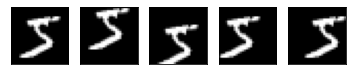

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=5)
example_shift = [train[0][1:] * 255, more_train[0] * 255, more_train[1] * 255, more_train[2] * 255, more_train[3] * 255]
for i, col in enumerate(ax):
        col.axes.get_xaxis().set_visible(False)
        col.axes.get_yaxis().set_visible(False)
        col.imshow(example_shift[i].reshape((28, 28)), cmap='gray')
        
plt.show()

# pytorch modeling

In [8]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as f
from torch.utils.data import TensorDataset, DataLoader
import copy

## data formatting

In [9]:
batch_size = 256
## t = torchvision.transforms.Compose([ torchvision.transforms.ToTensor() ])

In [10]:
# train_temp = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=t)
xtrain_tensor = torch.Tensor(xtrain)
ytrain_tensor = torch.Tensor(ytrain)
ytrain_tensor = ytrain_tensor.long()
mnist = torch.utils.data.TensorDataset(xtrain_tensor, ytrain_tensor)
mnist_dl = DataLoader(mnist, batch_size=batch_size)

xtest_tensor = torch.Tensor(xtest)
ytest_tensor = torch.Tensor(ytest)
mnist_test = torch.utils.data.TensorDataset(xtest_tensor, ytest_tensor)
mnist_test_dl = DataLoader(mnist_test)

## creating model

In [11]:
def mnist_lenet5_classifier():
    # input channel 1, output channel 6, kernel size 5
    # 2 convolutional layers + 3 linear layers
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10) 
    )
    
    return model

In [12]:
def prediction_accuracy(model, data):
    total_imgs = 0
    correct_preds = 0
    
    # data is a data loader
    for i, (images, labels) in enumerate(data):
        # digit output vector
        out = model(images)
        
        # maximum output value and its index (ie. the digit)
        value, pred = torch.max(out, 1)
        
        # count each image given as input; count correct
        total_imgs += out.size(0)
        correct_preds += torch.sum(pred == labels)
        
    return correct_preds * 100. / total_imgs
           

In [13]:
 def cnn_train(num_epoch=5, lr=1e-3, device='cpu'):
    accuracies = []
    max_accuracy = 0

    cnn = mnist_lenet5_classifier().to(device)
    cel = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)

    for ep in range(num_epoch):
        for i, (images, labels) in enumerate(mnist_dl):
            images = images.to(device)
            labels = labels.to(device)
            labels = torch.flatten(labels)
            
            # resets gradients
            optimizer.zero_grad()

            # outputs of model
            pred = cnn(images)

            # calculate loss + backpropagate
            loss = cel(pred, labels)
            loss.backward()

            # perform parameter update
            optimizer.step()

        acc = float(prediction_accuracy(cnn, mnist_test_dl))
        accuracies.append(acc)

        # select model w best prediction accuracy
        if acc > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = acc
            print(f'new best model with accuracy {acc}')

        print(f'epoch {ep+1}: accuracy {acc}')
            
    # plot prediction accuracies by epoch
    plt.plot(accuracies)
    
    return best_model

## training

new best model with accuracy 91.81800079345703
epoch 1: accuracy 91.81800079345703
new best model with accuracy 94.39600372314453
epoch 2: accuracy 94.39600372314453
new best model with accuracy 95.3479995727539
epoch 3: accuracy 95.3479995727539
new best model with accuracy 96.95999908447266
epoch 4: accuracy 96.95999908447266
new best model with accuracy 97.66600036621094
epoch 5: accuracy 97.66600036621094
new best model with accuracy 97.98200225830078
epoch 6: accuracy 97.98200225830078
new best model with accuracy 98.16400146484375
epoch 7: accuracy 98.16400146484375
new best model with accuracy 98.25199890136719
epoch 8: accuracy 98.25199890136719
new best model with accuracy 98.39399719238281
epoch 9: accuracy 98.39399719238281
new best model with accuracy 98.44000244140625
epoch 10: accuracy 98.44000244140625
new best model with accuracy 98.49600219726562
epoch 11: accuracy 98.49600219726562
new best model with accuracy 98.52200317382812
epoch 12: accuracy 98.52200317382812
new

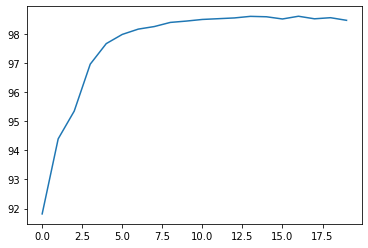

In [14]:
lenet = cnn_train(num_epoch=20)

In [39]:
torch.save(lenet, 'mnist_lenet.pth')

## inference

In [15]:
from sklearn.metrics import confusion_matrix

In [18]:
def predict(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        out = model(images)
        val, pred = torch.max(out, 1)
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
        
    return np.array(y_pred), np.array(y_true)

In [17]:
# visualizing predictions on the testing set
y_pred, y_true = predict(lenet, mnist_test_dl)
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,4878,0,3,0,0,2,0,3,5,9
1,1,5660,2,4,0,0,1,6,1,0
2,10,17,5073,19,4,0,1,25,6,5
3,0,0,3,5011,0,7,0,9,10,10
4,1,2,2,0,4836,0,16,8,1,44
5,3,0,0,59,0,4380,3,3,6,6
6,24,17,0,2,10,49,4668,0,20,0
7,1,14,42,6,1,0,0,5059,10,7
8,13,4,11,21,2,10,1,7,4790,11
9,4,5,1,12,31,2,0,19,23,4948


## testing on new data

In [19]:
import requests
import io
import cv2
from PIL import Image

In [29]:
response = requests.get('https://miro.medium.com/v2/resize:fit:451/0*kKxxK1YXSyWMEBtS.PNG')
bytes_im = io.BytesIO(response.content)
cv_im = cv2.cvtColor(np.array(Image.open(bytes_im).resize((28, 28))), cv2.COLOR_BGR2GRAY)
cv_im = cv_im.astype(np.float32) / 255
cv_im = torch.Tensor(np.asarray([[cv_im]]))
cv_im

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0235, 0.0745, 0.0863, 0.1020, 0.0941, 0.0941, 0.0667,
           0.0275, 0.0196, 0.0000, 0.0000, 

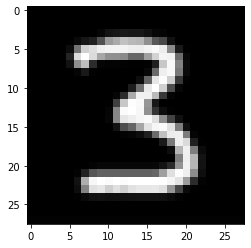

In [34]:
plt.imshow(cv_im.reshape((28,28)), cmap='gray')

In [38]:
out = lenet(cv_im)
probs = f.softmax(out, dim=-1).detach().numpy()
pred = np.argmax(probs)
print(f'predicted digit {pred} with probability {probs[0, pred]}')

predicted digit 3 with probability 1.0
